<a href="https://colab.research.google.com/github/mkaikaus/SeizureDetection/blob/master/seizuredetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
abhishekinnvonix_seizure_epilepcy_chb_mit_eeg_dataset_pediatric_path = kagglehub.dataset_download('abhishekinnvonix/seizure-epilepcy-chb-mit-eeg-dataset-pediatric')
masahirogotoh_mit_chb_processed_path = kagglehub.dataset_download('masahirogotoh/mit-chb-processed')

print('Data source import complete.')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging
import os
from sklearn import model_selection

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1','FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2','FZ-CZ', 'CZ-PZ']

In [ ]:
path2pt = '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0'

folders = sorted(glob.glob(path2pt+'/*/'))
n_patients = [m[-2:] for m in [l.rsplit('/',2)[-2] for l in folders]]
print(*n_patients)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [ ]:
random.seed(2023)
ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patients, round(ratio_train*len(n_patients))))
test_patient_str = sorted([l for l in n_patients if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [ ]:
files_train = []
for l in train_patient_str:
    files_train = files_train+glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [ ]:
len(files_train), len(files_test)

(549, 137)

In [ ]:
mne.set_log_level(verbose='ERROR')

In [ ]:
temp_edf = mne.io.read_raw_edf("/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf")
temp_edf

Measurement date,"November 07, 2076 01:44:44 GMT"
Experimenter,Unknown
Participant,Surrogate
Digitized points,Not available
Good channels,23 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


In [ ]:
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

time_window = 8
time_step = 4

if os.path.exists('/kaggle/input/mit-chb-processed/signal_samples.npy')&os.path.exists('/kaggle/input/mit-chb-processed/is_sz.npy'):
    array_signals=np.load('/kaggle/input/mit-chb-processed/signal_samples.npy')
    array_is_sz=np.load('/kaggle/input/mit-chb-processed/is_sz.npy')
else:
    p = 0.01
    counter = 0
    for temp_f in files_train:
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz = np.zeros((temp_edf.n_times,))
            if os.path.exists(temp_f+'.seizures'):
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            temp_len = temp_edf.n_times

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            counter = counter + temp_0_sample_size + temp_1_sample_size
        temp_edf.close()

    array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
    array_is_sz = np.zeros(counter, dtype=bool)

    counter = 0
    for n, temp_f in enumerate(tqdm.tqdm(files_train)):
        to_log = 'No. {}: Reading. '.format(n)
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
        if n_label_match==len(ch_labels):
            ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
            temp_edf.rename_channels(ch_mapping)
            #temp_edf = temp_edf.pick(ch_labels)

            temp_is_sz = np.zeros((temp_edf.n_times,))
            temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

            if os.path.exists(temp_f+'.seizures'):
                to_log = to_log+'sz exists.'
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            else:
                to_log = to_log+'No sz.'

            temp_len = temp_edf.n_times

            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )
            del temp_is_sz

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            # sz data
            temp_ind = list(np.where(temp_is_sz_ind>0)[0])
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = True
                counter = counter+1

            # no sz data
            temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = False
                counter = counter+1

            to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
                temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
            )

        else:
            to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)

        logger.info(to_log)
        temp_edf.close()

        if n%10==0:
            gc.collect()
    gc.collect()

    np.save('signal_samples', array_signals)
    np.save('is_sz', array_is_sz)

In [ ]:
array_signals = array_signals[:,:,::2]

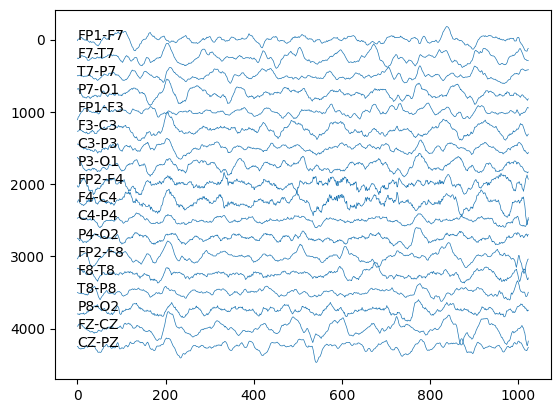

In [ ]:
vertical_width = 250
signals = array_signals[-1,:,:]

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1]),signals[i,:]+i*vertical_width,linewidth=0.5,color='tab:blue')
    ax.annotate(ch_labels[i],xy=(0,i*vertical_width))
ax.invert_yaxis()
plt.show()

In [ ]:
array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

Number of all the extracted signals: 9505
Number of signals with seizures: 2581
Ratio of signals with seizures: 0.272


In [ ]:
array_signals = array_signals[:,:,:,np.newaxis]
array_signals.shape

(9505, 18, 1024, 1)

In [ ]:
X_train,X_val,y_train,y_val = model_selection.train_test_split(
   array_signals,array_is_sz,test_size=0.3,stratify=(array_is_sz>0))

del array_signals , array_is_sz

In [ ]:
# Check shapes
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(6653, 18, 1024, 1) (6653,) (2852, 18, 1024, 1) (2852,)


In [ ]:
class MyDataset(Dataset):
    def __init__(self,X,y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2024-05-24 16:22:23.926835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 16:22:23.926961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 16:22:24.072105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def resnet_block(x, filters, kernel_size):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def eegnet_block(x):
    # Depthwise Convolution
    x = DepthwiseConv2D((1, 64), use_bias=False, depth_multiplier=2)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # Average Pooling
    x = AveragePooling2D((1, 4))(x)

    # Convolution
    x = Conv2D(16, (1, 1), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # Average Pooling
    x = AveragePooling2D((1, 4))(x)
    return x

In [ ]:
def create_model():
    model = keras.models.Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((1, 2)))

    model.add(layers.Conv2D(128, (2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Concatenation
    model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))


    model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
    model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((1, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
def generate_client_data():
    x_train = X_train
    y_tran = y_train
    return x_train, y_tran

In [ ]:
import keras
from keras import layers, models

In [ ]:
def federated_learning(num_clients, num_epochs, log_file,  x_val, y_val):
    # Create a central server model
    global_model = create_model()

    # Open log file
    with open(log_file, 'w') as f:
        f.write("Client,Epoch,Train Loss,Train Accuracy\n")

        # Simulate multiple clients
        for client_id in range(num_clients):
            # Generate client data
            x_train, y_train = generate_client_data()

            # Create and compile local model
            local_model = create_model()
            local_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            # Train local model
            for epoch in range(num_epochs):
                history = local_model.fit(x_train, y_train, epochs=1, verbose=0)
                train_loss = history.history['loss'][0]
                train_accuracy = history.history['accuracy'][0]

               # Validate local model
                val_loss, val_accuracy = local_model.evaluate(x_val, y_val, verbose=0)

                # Log training and validation progress
                f.write(f"{client_id},{epoch + 1},{train_loss},{train_accuracy},{val_loss},{val_accuracy}\n")

            # Get local model weights
            local_weights = local_model.get_weights()

            # Send local model weights to central server (for simplicity, just update global model)
            global_model.set_weights(local_weights)

    return global_model

In [ ]:
num_clients = 4
num_epochs = 20
log_file = 'training_log.csv'
final_global_model = federated_learning(num_clients, num_epochs, log_file, X_val, y_val)

# Now you have the final global model trained using federated learning

print("Training log saved to", log_file)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
I0000 00:00:1716567774.320018      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training log saved to training_log.csv


In [ ]:
def sampling_data_pred(f, verbose=True):
    list_signals = []
    list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        #else:
            #print('No sz.', end=' ')

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [ ]:
list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]

    list_pred.append(final_global_model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

100%|██████████| 137/137 [05:07<00:00,  2.24s/it]


In [ ]:
# Concatenate all predictions and true labels
all_pred = np.concatenate(list_pred).flatten()
all_true = np.concatenate(list_true).flatten()

# Binarize predictions based on a threshold of 0.5
all_pred_binary = all_pred > 0.5
all_true_binary = all_true > 0

In [ ]:
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.99      0.99    186865
        True       0.15      0.43      0.22       629

    accuracy                           0.99    187494
   macro avg       0.57      0.71      0.61    187494
weighted avg       1.00      0.99      0.99    187494



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tqdm

Accuracy: 0.99
Precision: 0.15
Recall: 0.43
F1 Score: 0.22


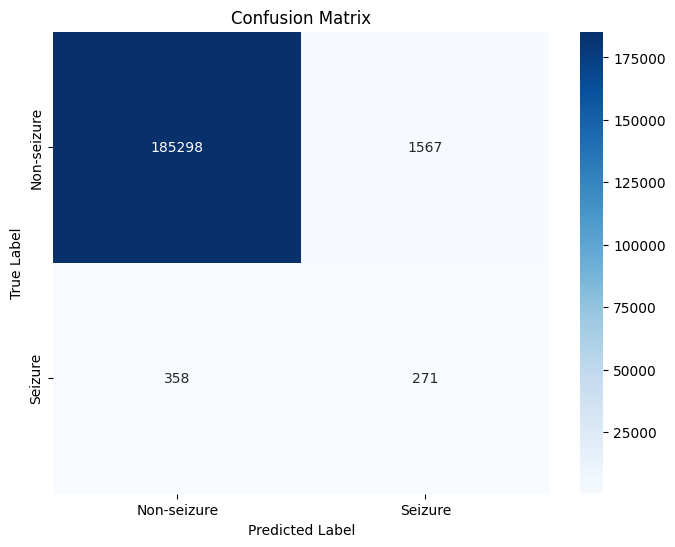

In [ ]:
# Compute confusion matrix
conf_matrix = metrics.confusion_matrix(all_true_binary, all_pred_binary)

# Extract confusion matrix elements
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate accuracy, precision, recall, and F1 score
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the calculated metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-seizure', 'Seizure'], yticklabels=['Non-seizure', 'Seizure'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))

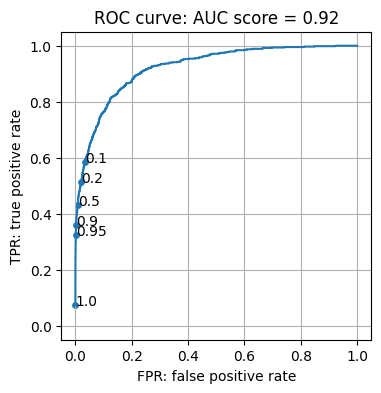

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

In [ ]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

Index = 9 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_18.edf
Index = 11 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_26.edf
Index = 12 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf
Index = 20 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_16.edf
Index = 24 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf
Index = 30 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_21.edf
Index = 37 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf
Index = 50 has seizures: /kaggle/in

In [ ]:
def moving_ave(a, n):
    if len(a.shape)!=1:
        print('Not 1 dimension array. return nothing.')
        return
    temp = np.zeros(a.size-n)
    for i in range(n):
        temp = temp+a[i:-n+i]
    temp = temp/n

    return temp

In [ ]:
# get signals and labels from test data.
n=100
array_signals, array_is_sz = sampling_data_pred(files_test[n])

# preprocess
array_signals=array_signals[:, :, ::2, np.newaxis]

# use deep learning model
pred = final_global_model.predict(array_signals)

/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_89.edf: Reading. 
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


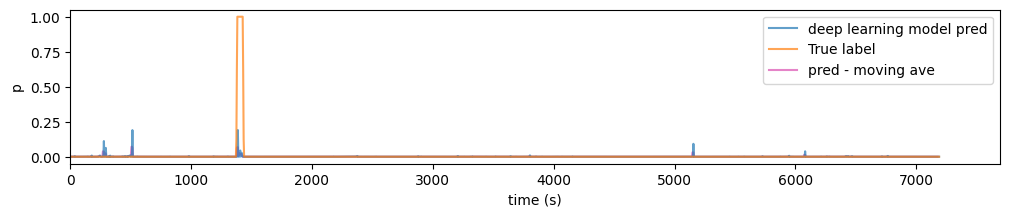

In [ ]:
time_window = 8
time_step = 4
mv_win = 3

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(pred.size)*time_step, pred.flatten(), alpha=0.7, label='deep learning model pred')
ax.plot(np.arange(pred.size)*time_step, array_is_sz, alpha=.7, label='True label')

pred_moving_ave = moving_ave(pred.flatten(), mv_win)
pred_peaks, _ = find_peaks(pred_moving_ave, height=.95, distance=6)
ax.plot(np.arange(pred.size-mv_win)*time_step, pred_moving_ave,
        alpha=.9, label='pred - moving ave', color='tab:pink', zorder=0)
ax.scatter(pred_peaks*time_step, pred_moving_ave[pred_peaks], s=20, color='tab:red')

ax.set_xlabel('time (s)')
ax.set_ylabel('p')
ax.set_xlim(0, pred.size*time_step+500)
ax.legend(loc='upper right')
plt.show()

In [ ]:
    if pred_peaks.size == 0:
        print('No seizure detected.')
    else:
        f = files_test[n]
        temp_edf = mne.io.read_raw_edf(f)
        temp_labels = temp_edf.ch_names
        if sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):
            ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) is not None])[0]: c for c in ch_labels}
            temp_edf.rename_channels(ch_mapping)

            temp_is_sz = np.zeros((temp_edf.n_times,))
            temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))
        for n_peak in range(pred_peaks.size):
            ind_peak = int(pred_peaks[n_peak] * time_step * fs)
            backward_steps = 30 * fs
            forward_steps = 15 * fs
            vertical_width = 500

            fig, ax = plt.subplots(figsize=(12, 8))
            fig.patch.set_facecolor('white')
            ax.set_facecolor('white')

            for i in range(temp_signals.shape[0]):
                ax.plot(np.arange(ind_peak - backward_steps, ind_peak + forward_steps) / fs,
                        temp_signals[i, ind_peak - backward_steps:ind_peak + forward_steps] + i * vertical_width,
                        linewidth=1, color='cyan', linestyle='-')
                ax.annotate(ch_labels[i], xy=((ind_peak - backward_steps) / fs, i * vertical_width), color='white')

            ax.axvline(x=ind_peak / fs, color='red', alpha=1, linestyle='--')
            ax.invert_yaxis()
            ax.legend(loc='upper right', fontsize='large', facecolor='white', edgecolor='white')

#             ax.set_title('Seizure Detection', color='black', fontsize=16)
#             ax.set_xlabel('Time (s)', color='black')
#             ax.set_ylabel('Amplitude (uV)', color='black')
#             ax.tick_params(colors='black')

            # Save the figure
            plt.savefig(f'seizure_detection_{n_peak}.png', bbox_inches='tight', facecolor=fig.get_facecolor())
            plt.show()

        temp_edf.close()

No seizure detected.
